This uses the results of running `RL_discrete_1q_space_v20_lambda.py` on lambda, and obtaining the files `optimal_policy_discrete_1q_v20.p` and `V_optimal_discrete_1q_v20.p`.<br>
This is essentially the same as `RL_discrete_1q_lambda_run_v20` except that it uses the environment from `RL_discrete_1q_space v20` to actually compute the optimal programs (note the difference in `reset`), even though this was **not** the environment that was used in the actual file `RL_discrete_1q_space_v20_lambda.py`.

In [1]:
import gym
import gym.spaces
import numpy as np
from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
import sys
# from pyquil.api._base_connection import ForestConnection
import pickle

from collections import defaultdict
import sys

In [2]:
# identify discrete gates on qubit 0
num_angles = 1000
angles = np.linspace(0.0, 2 * np.pi, num_angles)
gates = [RY(theta, 0) for theta in angles]
gates += [RZ(theta, 0) for theta in angles]

In [3]:
class OneQEnv(gym.Env):
    
    def __init__(self, goal_angles, bins=(4, 8)):
        # WavefunctionSimulator
        self.wfn_sim = WavefunctionSimulator()
        # Identify discrete state space grid
        self._bins = bins
        self._grid = self.create_uniform_grid(bins=self._bins)
        # Identify desired state
        self.goal_angles = goal_angles
        self.goal_state = self.polar_angles_to_state(self.goal_angles)
        # Create rewards dictionary
        self.d_rewards = defaultdict(lambda: 0)
        self.d_rewards[self.goal_state] = 1
        # Identify discrete state space
        self.state_space = gym.spaces.Discrete((self._bins[0] - 2) * self._bins[1] + 2)
        self.observation_space = self.state_space
        # Identify discrete action space
        self._actions = gates
        self.action_space = gym.spaces.Discrete(len(self._actions))
        # Identify sizes of state and action spaces
        self.nS = self.state_space.n
        self.nA = self.action_space.n
        # Initialize to identity program
        self._program = Program(I(0))
        # Identify state
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks for polar angles
        assert self._theta >= 0.0 and self._theta <= np.pi
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi
        self.info = {}
        
        
    def reset(self, state=None):
        if state is None:
            state = np.random.choice(self.nS)
        assert state in range(self.nS), "Invalid state"
        angles = self.state_to_polar_angles(state)
        assert state == self.polar_angles_to_state(angles), f"Something went wrong in reset for state {state}"
        # consistency checks
        assert angles[0] >= 0.0 and angles[0] <= np.pi
        assert angles[1] >= 0.0 and angles[1] <= 2 * np.pi

        self.polar_angles_to_prog(angles)
        self.wfn_to_polar_angles()
        self.state = state
        return self.state
    
    
    def step(self, action, shuffle=False):
        
        if shuffle:
            return self.step_shuffle(action)
        
        else:
            return self.step_old(action)
        
        
    def step_old(self, action):
        self._program += self._actions[action]
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = 0
            done = False

        return self.state, reward, done, self.info


    def step_shuffle(self, action):

        self._program += self._actions[action]

        # first, get polar angles from the new program
        self.wfn_to_polar_angles()

        # identify the resultant state
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        
        # get back the angles from this state
        theta, phi = self.state_to_polar_angles(self.state)
        assert self.state == self.polar_angles_to_state([theta, phi]), f"Something went wrong in step"
        
        # set the angles to these new values
        self._theta = theta
        self._phi = phi

        # convert the perturbed polar angles to new program
        self.polar_angles_to_prog([self._theta, self._phi])

        # convert the perturbed polar angles to new wavefunction
        self.wfn_to_polar_angles()

        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"

        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = 0
            done = False

        return self.state, reward, done, self.info


    @classmethod
    def amps_to_polar_angles(self, z):
        # NOTE: This is a poorly named function
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        return r, angle
    
    
    @classmethod
    def amps_to_actual_polar_angles(self, z):
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        cos_theta_over_2 = np.abs(r[0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        theta = 2 * np.arccos(cos_theta_over_2)
        theta = theta % (np.pi)
        phi = angle[1] - angle[0]
        if phi < 0.0: phi += 2 * np.pi
        phi = phi % (2 * np.pi)
        return theta, phi


    def wfn_to_polar_angles(self):
        self._wfn = self.wfn_sim.wavefunction(self._program)
        self._wfn_amps = self._wfn.amplitudes
        self._wfn_polar = self.amps_to_polar_angles(self._wfn_amps)
        cos_theta_over_2 = np.abs(self._wfn_polar[0][0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        self._theta = 2 * np.arccos(cos_theta_over_2)
        if self._theta < 0.0: self._theta = -self._theta
        self._phi = self._wfn_polar[1][1] - self._wfn_polar[1][0]
        if self._phi < 0.0: self._phi += 2 * np.pi
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"


    def create_uniform_grid(self, bins):
        # create grid for angles
        low=[0.0, 0.0]
        high=[np.pi, 2 * np.pi]
        grid_list = []
        for i in range(len(low)):
            tmp_high = high[i]
            tmp_low = low[i]
            tmp_bin = bins[i]
            tmp_diff = (tmp_high - tmp_low) / tmp_bin
            tmp_arr = np.linspace(tmp_low + tmp_diff, tmp_high - tmp_diff, tmp_bin - 1)
            grid_list.append(tmp_arr)
        return grid_list
    
    
    def discretize(self, sample, grid):
        # Discretize a sample as per given grid.
        samps = []
        dims = len(grid)
        for i in range(dims):
            tmp_samp = np.digitize(np.round(sample[i], 2), np.round(grid[i], 2))
            samps.append(tmp_samp)

        samps = np.array(samps)
        assert samps.shape == (dims, )
        return samps


    def state_number(self, discrete_sample, mygrid):
        # expecting an array with 2 entries
        if discrete_sample[0] == 0:
            return 0
        elif discrete_sample[0] == self._bins[0] - 1:
            return (self._bins[0] - 2) * self._bins[1] + 1
        else:
            return (discrete_sample[0] - 1) * self._bins[1] + discrete_sample[1] + 1


    def state_to_polar_angles(self, state_num):
        delta_theta = np.round(self._grid[0][0], 3)
        delta_phi = np.round(self._grid[1][0], 3)
        assert state_num in range(self.nS)
        if state_num == 0:
            theta = 0.0
            phi = 0.0
#             theta = max(0.0 + np.random.uniform(0.0, delta_theta) - 0.01, 0.0)
#             phi = max(0.0 + np.random.uniform(0.0, 2 * np.pi) - 0.01, 0.0)
                    
        elif state_num == (self._bins[0] - 2) * self._bins[1] + 1:
            theta = max(np.pi - delta_theta, np.pi - delta_theta + np.random.uniform(0.0, delta_theta) - 0.01)
            phi = max(0.0 + np.random.uniform(0.0, 2 * np.pi) - 0.01, 0.0)
                    
        else:
            N = self._bins[0]
            M = self._bins[1]
            theta = (np.pi / N) * ((state_num - 1) // M + 1)
            theta = max(theta, theta + np.random.uniform(0.0, delta_theta) - 0.01)
            phi = (2 * np.pi / M) * ((state_num - 1) % M)
            phi = max(phi, phi + np.random.uniform(0.0, delta_phi) - 0.01)

        theta = theta % (np.pi)
        phi = phi % (2 * np.pi)
        # consistency checks
        assert theta >= 0.0 and theta <= np.pi, f"theta: {theta}"
        assert phi >= 0.0 and phi <= 2 * np.pi, f"phi: {phi}"
        return theta, phi
    

    def polar_angles_to_state(self, angles):
        discrete_sample = self.discretize(sample=angles, grid=self._grid)
        state_number = self.state_number(discrete_sample, mygrid=self._grid)
        return state_number
    
    
    def polar_angles_to_prog(self, angles):
        theta = angles[0]
        phi = angles[1]
        self._program = Program(RY(theta, 0), RZ(phi, 0))

In [4]:
env = OneQEnv(goal_angles=np.array([np.pi, 0.0]), bins=(16, 32))
print(f"No. of states: {env.nS}")

No. of states: 450


In [6]:
optimal_policy = pickle.load(open('../optimal_policy_discrete_1q_v20.p', 'rb'))

In [7]:
d_optimal_prog = {}

for s in range(env.nS):
    
    converged = False

    while not converged:

        original_state = env.reset(s)
        original_angles = env.state_to_polar_angles(s)
        original_wfn = env.wfn_sim.wavefunction(env._program)

        state = s
        prog = Program()
        done = False
        counter = 0
        converged = False

        while not done:
            action = np.argmax(optimal_policy[state])
            prog += env._actions[action]
            next_state, reward, done, info = env.step(action)
            state = next_state
            counter += 1
            if counter > 50:
                break
                
        if done:
            converged = True
            print(f"original state: {original_state}")
            print(f"Polar angles: {original_angles}")
            print(f"Original wavefunction: {original_wfn}")
            print("\n")
            d_optimal_prog[s] = prog
            print("Optimal program")
            print(prog)
            print("Final wavefunction")
            print(env._wfn)
            print("Final outcome probabilities")
            print(env._wfn.get_outcome_probs())
            print("*" * 30)

original state: 0
Polar angles: (0.0, 0.0)
Original wavefunction: (1+0j)|0>


Optimal program
RY(3.138447916198812) 0

Final wavefunction
(0.001572368+0j)|0> + (0.9999987638+0j)|1>
Final outcome probabilities
{'0': 2.472341277065505e-06, '1': 0.999997527658723}
******************************
original state: 1
Polar angles: (0.2691811095002191, 0.09756334388431027)
Original wavefunction: (0.9846135907-0.0470979655j)|0> + (0.1680869204+0.0080402628j)|1>


Optimal program
RY(2.748500479717196) 0

Final wavefunction
(0.0274276532-0.017082899j)|0> + (0.9984812766-0.0446210571j)|1>
Final outcome probabilities
{'0': 0.0010441016018172373, '1': 0.9989558983981829}
******************************
original state: 2
Polar angles: (0.1991551556996153, 0.32581612390841397)
Original wavefunction: (0.9857624599-0.1135564692j)|0> + (0.1231905546+0.0141911312j)|1>


Optimal program
RY(2.773658378845042) 0

Final wavefunction
(0.0592149048-0.034724687j)|0> + (0.9916638216-0.1090442847j)|1>
Final outcome 

In [8]:
prog_lengths = [len(v) for v in d_optimal_prog.values()]

(array([ 84.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 341.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ,
        1.88, 1.96, 2.04, 2.12, 2.2 , 2.28, 2.36, 2.44, 2.52, 2.6 , 2.68,
        2.76, 2.84, 2.92, 3.  , 3.08, 3.16, 3.24, 3.32, 3.4 , 3.48, 3.56,
        3.64, 3.72, 3.8 , 3.88, 3.96, 4.04, 4.12, 4.2 , 4.28, 4.36, 4.44,
        4.52, 4.6 , 4.68, 4.76, 4.84, 4.92, 5.  ]),
 <a list of 50 Patch objects>)

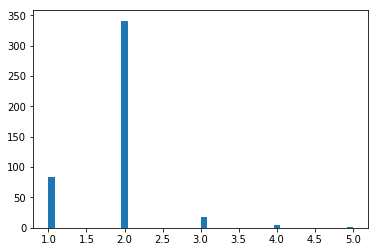

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(prog_lengths, bins=50)

### Analyze a single non-optimal "optimal" program

In [10]:
non_optimal_3 = [k for k, v in d_optimal_prog.items() if len(v) == 3]
len(non_optimal_3)

18

In [15]:
# non_optimal_3[2]

66

In [16]:
# print(d_optimal_prog[66])

RY(2.4843425388748113) 0
RZ(0.7610264486173473) 0
RY(5.924685244607778) 0



In [17]:
for s in non_optimal_3:
    print(f"s: {s}")
    print(d_optimal_prog[s])
    print("\n")

s: 12
RY(3.283105836183928) 0
RZ(1.1635528346628863) 0
RY(5.924685244607778) 0



s: 62
RY(2.7296320553713116) 0
RZ(0.7421580242714626) 0
RY(0.2390000417145388) 0



s: 66
RY(2.4843425388748113) 0
RZ(0.7610264486173473) 0
RY(5.924685244607778) 0



s: 82
RY(3.7988427683047745) 0
RZ(0.9560001668581553) 0
RY(0.2390000417145388) 0



s: 98
RY(2.239053022378311) 0
RZ(1.1635528346628863) 0
RY(5.924685244607778) 0



s: 114
RY(4.050421759583236) 0
RZ(1.3836844520315403) 0
RY(0.2390000417145388) 0



s: 127
RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0
RY(0.18868424345884643) 0



s: 171
RZ(0.9748685912040398) 0
RZ(0.18868424345884643) 0
RY(4.421500771718968) 0



s: 219
RZ(4.119605982184813) 0
RZ(0.20126319302276952) 0
RY(4.566158691704083) 0



s: 327
RZ(1.7610529389492333) 0
RZ(0.18239476867688487) 0
RY(5.346053564667315) 0



s: 346
RZ(1.1446844103170015) 0
RZ(0.18868424345884643) 0
RY(0.8113422468730396) 0



s: 348
RZ(0.7861843477451934) 0
RY(0.8113422468730396) 0
RY(0.188684243458

In [26]:
# for s in range(env.nS):
optimal_progs = []

for s in [127]:
    
    converged = False

    while not converged:

        original_state = env.reset(s)
        original_angles = env.state_to_polar_angles(s)
        original_wfn = env.wfn_sim.wavefunction(env._program)

        state = s
        prog = Program()
        done = False
        counter = 0
        converged = False

        while not done:
            action = np.argmax(optimal_policy[state])
            prog += env._actions[action]
            next_state, reward, done, info = env.step(action)
            state = next_state
            counter += 1
            if counter > 50:
                break
                
        if done:
            converged = True
            print(f"original state: {original_state}")
            print(f"Polar angles: {original_angles}")
            print(f"Original wavefunction: {original_wfn}")
            print("\n")
#             d_optimal_prog_v2[s] = prog
            print("Optimal program")
            print(prog)
            print("Final wavefunction")
            print(env._wfn)
            print("Final outcome probabilities")
            print(env._wfn.get_outcome_probs())
            print("*" * 30)

original state: 127
Polar angles: (0.788385747618893, 5.966338654908558)
Original wavefunction: (-0.9070783439-0.1178870418j)|0> + (-0.4007479595+0.0520825922j)|1>


Optimal program
RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0

Final wavefunction
(-0.0603396078-0.0271654841j)|0> + (-0.997567957-0.0218938216j)|1>
Final outcome probabilities
{'0': 0.004378831795867359, '1': 0.9956211682041327}
******************************


In [ ]:
# original state: 127
# Polar angles: (0.788385747618893, 5.966338654908558)
# Original wavefunction: (-0.9070783439-0.1178870418j)|0> + (-0.4007479595+0.0520825922j)|1>


# Optimal program
# RZ(0.18868424345884643) 0
# RY(2.1887372241226184) 0

# Final wavefunction
# (-0.0603396078-0.0271654841j)|0> + (-0.997567957-0.0218938216j)|1>
# Final outcome probabilities
# {'0': 0.004378831795867359, '1': 0.9956211682041327}
# ******************************

In [28]:
print(d_optimal_prog[127])

RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0
RY(0.18868424345884643) 0



In [29]:
s = 127

optimal_progs = []

for i in range(100):
    
    print(f"\rExperiment {i+1} / 100", end="")
    sys.stdout.flush()
    
    converged = False
    
    while not converged:
        
        original_state = env.reset(s)
        original_angles = env.state_to_polar_angles(s)
        original_wfn = env.wfn_sim.wavefunction(env._program)
        
        state = s
        prog = Program()
        done = False
        counter = 0
        converged = False
        
        while not done:
            action = np.argmax(optimal_policy[state])
            prog += env._actions[action]
            next_state, reward, done, info = env.step(action)
            state = next_state
            counter += 1
            if counter > 50:
                break
                
        if done:
            converged = True
            optimal_progs.append(prog)

Experiment 100 / 100

In [30]:
min([len(p) for p in optimal_progs])

2

(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.]),
 array([2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18, 2.2 ,
        2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 , 2.42,
        2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 , 2.62, 2.64,
        2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82, 2.84, 2.86,
        2.88, 2.9 , 2.92, 2.94, 2.96, 2.98, 3.  ]),
 <a list of 50 Patch objects>)

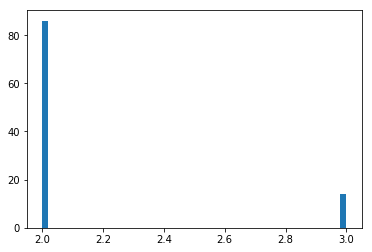

In [31]:
prog_lengths = [len(p) for p in optimal_progs]
plt.hist(prog_lengths, bins=50)

In [32]:
for p in optimal_progs:
    print(p)
    print("\n")

RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0.18868424345884643) 0
RZ(0.18868424345884643) 0
RY(2.1887372241226184) 0



RZ(0

In [ ]:
# d_optimal_prog = {}

# for s in range(env.nS):
    
#     converged = False

#     while not converged:

#         original_state = env.reset(s)
#         original_angles = env.state_to_polar_angles(s)
#         original_wfn = env.wfn_sim.wavefunction(env._program)

#         state = s
#         prog = Program()
#         done = False
#         counter = 0
#         converged = False

#         while not done:
#             action = np.argmax(optimal_policy[state])
#             prog += env._actions[action]
#             next_state, reward, done, info = env.step(action)
#             state = next_state
#             counter += 1
#             if counter > 50:
#                 break
                
#         if done:
#             converged = True
#             print(f"original state: {original_state}")
#             print(f"Polar angles: {original_angles}")
#             print(f"Original wavefunction: {original_wfn}")
#             print("\n")
#             d_optimal_prog[s] = prog
#             print("Optimal program")
#             print(prog)
#             print("Final wavefunction")
#             print(env._wfn)
#             print("Final outcome probabilities")
#             print(env._wfn.get_outcome_probs())
#             print("*" * 30)